   Age     Sex  Cholesterol  Heart Rate  Diabetes  Family History  Smoking  \
0   67    Male          208          72         0               0        1   
1   21    Male          389          98         1               1        1   
2   21  Female          324          72         1               0        0   
3   84    Male          383          73         1               1        1   
4   66    Male          318          93         1               1        1   

   Obesity  Alcohol Consumption  Exercise Hours Per Week  ... Medication Use  \
0        0                    0                 4.168189  ...              0   
1        1                    1                 1.813242  ...              0   
2        0                    0                 2.078353  ...              1   
3        0                    1                 9.828130  ...              0   
4        1                    0                 5.804299  ...              0   

   Stress Level  Sedentary Hours Per Day        BM

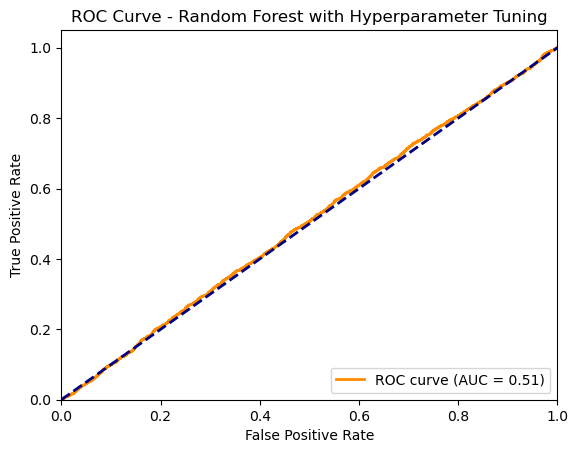

Test Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       0.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.32      0.50      0.39      1753
weighted avg       0.41      0.64      0.50      1753



c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elvis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd

# Load the lifestyle dataset
lifestyle_data = pd.read_csv('../datasets/lifestyle_dataset.csv')

# Split the 'Blood Pressure' column into 'Systolic_BP' and 'Diastolic_BP'
blood_pressure_split = lifestyle_data['Blood Pressure'].str.split('/', expand=True)
lifestyle_data['Systolic_BP'] = pd.to_numeric(blood_pressure_split[0], errors='coerce')
lifestyle_data['Diastolic_BP'] = pd.to_numeric(blood_pressure_split[1], errors='coerce')

# Drop the original 'Blood Pressure' column
lifestyle_data = lifestyle_data.drop(columns=['Blood Pressure'])

# Dropping additional columns from the lifestyle dataset
columns_to_remove = ['Hemisphere', 'Patient ID', 'Income', 'Continent', 'Country']
lifestyle_data = lifestyle_data.drop(columns=columns_to_remove)

# Preprocessing the lifestyle dataset by dropping the output column
Xlifestyle = lifestyle_data.drop('Heart Attack Risk', axis=1)
Ylifestyle = lifestyle_data['Heart Attack Risk']

# Identify categorical columns
categorical_columns_lifestyle = ['Sex', 'Diabetes', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 
                      ]

# Create a column transformer for handling categorical features (only one-hot encoding for categorical columns)
life_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns_lifestyle)  # One-hot encode categorical columns
    ], remainder='passthrough'  # Leave numeric columns as-is (no scaling)
)

# Print the first 5 rows of the lifestyle_data to inspect the data
print(lifestyle_data.head())
# Print the column names of the lifestyle_data dataframe
print(lifestyle_data.columns)

# Identify non-numeric entries in the numeric columns
non_numeric = Xlifestyle.apply(lambda x: pd.to_numeric(x, errors='coerce').isna())
print("Non-numeric entries in numeric columns:")
print(non_numeric.any())



# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(Xlifestyle, Ylifestyle, test_size=0.2, random_state=42)

# Check the shape of the preprocessed data
print("Shape of preprocessed X data:", X_train.shape)
print("Shape of Y_train data:", Y_train.shape)


# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Create a pipeline that includes the preprocessor and the Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', life_preprocessor),  # Only handles categorical data (no scaling)
    ('rf', rf)
])

# Define the hyperparameters to tune
param_grid = {
    'rf__n_estimators': [50, 100, 200],              # Number of trees
    'rf__max_depth': [None, 10, 20, 30],             # Maximum depth of each tree
    'rf__min_samples_split': [2, 5, 10],             # Minimum samples to split a node
    'rf__min_samples_leaf': [1, 2, 4]                # Minimum samples at a leaf node
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_train, Y_train)

# Get the best parameters and the best score from GridSearchCV
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Cross-validation Accuracy: {:.2f}".format(grid_search.best_score_))

# Use cross_val_predict to get the predicted probabilities for each fold (best estimator)
cv = StratifiedKFold(n_splits=5)
y_pred_proba = cross_val_predict(grid_search.best_estimator_, X_train, Y_train, cv=cv, method='predict_proba')

# Use the second column which contains the probabilities for the positive class (i.e., class 1)
y_pred_proba_positive = y_pred_proba[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(Y_train, y_pred_proba_positive)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest with Hyperparameter Tuning')
plt.legend(loc="lower right")
plt.show()

# Evaluate the best model on the test set
Y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Test Accuracy: {:.2f}".format(accuracy))
print("Classification Report:\n", classification_report(Y_test, Y_pred))
